# data import

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
#import s3fs
import io

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [42]:
df_combined = pd.read_csv('data/exported/df_combined.csv', index_col = 0)
df_not_combined = pd.read_csv('data/exported/df_not_combined.csv', index_col = 0)
#df_yeast_not_combined = pd.read_csv(io.BytesIO(uploaded['df_yeast_not_combined.csv']), index_col = 0)
#df_yeast_combined = pd.read_csv(io.BytesIO(uploaded['df_yeast_combined.csv']), index_col = 0)

# modelling packages

In [43]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report, adjusted_rand_score, adjusted_mutual_info_score 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from pprint import pprint
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

In [44]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object", "ref_pos":"object"})

In [45]:
df_combined = df_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_combined = df_combined.astype({"ref_number":"object", "ref_pos":"object"})

In [46]:
seed = 7

## train test split

In [47]:
df_dum = pd.get_dummies(df_not_combined[["base_1","base_2","base_3","base_4","base_5"]])
df_dum = pd.concat([df_not_combined, df_dum], axis = 1)
df_dum = df_dum.drop(["base_1","base_2","base_3","base_4","base_5"], axis = 1)

In [48]:
df_dum_num = df_dum[df_dum.select_dtypes(include=[np.number]).columns.values]

In [49]:
results = []
for file_name in df_dum.file_name.unique():
    msk1 = df_dum[df_dum.file_name == file_name]
    for ref_num in msk1.ref_number.unique():
        msk2 = msk1[msk1.ref_number == ref_num]
        for read_num in msk2.read_num.unique():
            msk3 = (df_dum.file_name == file_name) & (df_dum.ref_number == ref_num) & (df_dum.read_num == read_num)
            results.append(df_dum_num[msk3])

In [21]:
X_3d = np.stack(results)

In [22]:
y_3d_array = []
for file_name in df_dum.file_name.unique():
    msk1 = df_dum[df_dum.file_name == file_name]
    for ref_num in msk1.ref_number.unique():
        msk2 = msk1[msk1.ref_number == ref_num]
        for read_num in msk2.read_num.unique():
            msk3 = (df_dum.file_name == file_name) & (df_dum.ref_number == ref_num) & (df_dum.read_num == read_num)
            y_3d_array.append(df_dum[msk3].modified_status)

In [27]:
y_3d = np.stack(y_3d_array)

In [33]:
X_3d_finaltest, X_3d_val, y_3d_finaltest, y_3d_val = train_test_split(X_3d, y_3d, random_state = seed)

In [34]:
X_3d_train, X_3d_test, y_3d_train, y_3d_test = train_test_split(X_3d_finaltest, y_3d_finaltest, random_state = seed)

# Pipeline

In [51]:
numeric_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "float"])

In [52]:
numeric_features_not_combined

['dwell_time',
 'median_value',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min']

In [53]:
cat_features_not_combined = list(X_train_not_combined.columns[X_train_not_combined.dtypes ==  "category"])

In [54]:
cat_features_not_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [55]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_not_combined = SimpleImputer(strategy="median")
scaler1_not_combined = StandardScaler()
numeric_transformer_not_combined = make_pipeline(imputer1_not_combined,scaler1_not_combined)


imputer2_not_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_not_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_not_combined = make_pipeline(imputer2_not_combined,encoder_not_combined)

preprocessor_not_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined),
        ('cat', cat_transformer_not_combined, cat_features_not_combined)
    ])

# rnn

In [56]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [57]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [58]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [59]:
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


In [64]:
len (X_3d_train)

646

In [68]:
FEATURES = X_3d_finaltest.shape[2]
N_TRAIN = len(X_3d_train)
BUFFER_SIZE = len(X_3d_train)
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
METRICS = ["sparse_categorical_accuracy"]


In [61]:
X_resample, y_resample = smotet.fit_resample(preprocessor_not_combined.fit_transform(X_test_not_combined), y_test_not_combined)
X_train_resample, y_train_resample = smotet.fit_resample(preprocessor_not_combined.fit_transform(X_train_not_combined), y_train_not_combined)

In [69]:
train_ds = tf.data.Dataset.from_tensor_slices((X_3d_train,y_3d_train))
validate_ds = tf.data.Dataset.from_tensor_slices((X_3d_test,y_3d_test))

In [70]:
validate_ds = validate_ds.batch(BATCH_SIZE, drop_remainder = True)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE, drop_remainder = True)

In [71]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(196,FEATURES)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [78]:
optimizer = get_optimizer()
model.compile(optimizer=optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                23296     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________


In [79]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=200),
    ]

In [80]:
history={}

In [81]:
history["tiny"] = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=10000,
    validation_data=validate_ds,
    callbacks=get_callbacks("tiny model"),
    verbose=0)


Epoch: 0, 


ValueError: logits and labels must have the same shape ((100, 1) vs (100, 196))

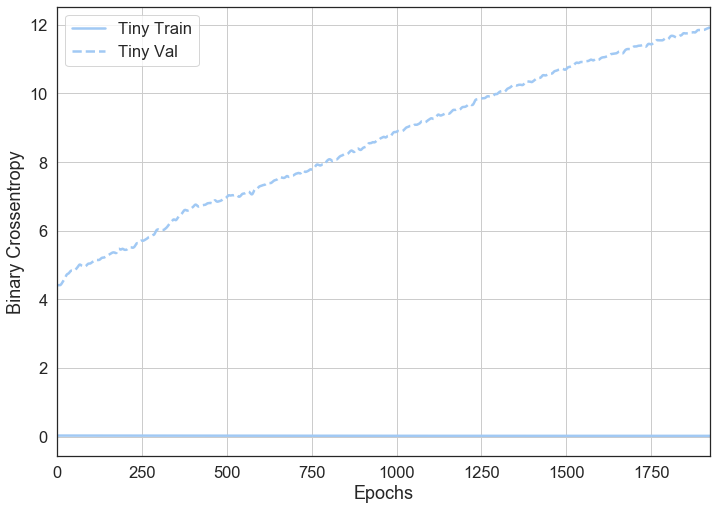

In [193]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(history)

In [ ]:
y_pred = model.predict_classes(preprocessor_not_combined.fit_transform(X_val_not_combined))

In [ ]:
print (classification_report(y_val_not_combined, y_pred))